## Import Libraries & Dataset

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("Online Retail.xlsx")


print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


## Prepare the Data

In [4]:
df = df.dropna(subset=["CustomerID"])

df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

## Create RFM Table

In [5]:
import datetime as dt


reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
})


rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalAmount": "Monetary"
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          2      0.00
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


## Assign RFM Scores


In [6]:

rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])


rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

print(rfm.head())

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12346.0         326          2      0.00       1       2       1       121
12347.0           2          7   4310.00       4       4       4       444
12348.0          75          4   1797.24       2       3       4       234
12349.0          19          1   1757.55       3       1       4       314
12350.0         310          1    334.40       1       1       2       112


## Define Segments

In [ ]:
import re

def segment_customer(rfm_score):
    if re.match(r'[4][4][4]', rfm_score):  
        return "Champions"
    elif re.match(r'[3-4][3-4][3-4]', rfm_score):
        return "Loyal Customers"
    elif re.match(r'[4][1-2][1-2]', rfm_score):
        return "Potential Loyalist"
    elif re.match(r'[2-3][2-3][1-2]', rfm_score):
        return "At Risk"
    elif re.match(r'[1][1-2][1-2]', rfm_score):
        return "Lost Customers"
    else:
        return "Others"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)
print(rfm["Segment"].value_counts())

Segment
Others                1459
Loyal Customers        854
Lost Customers         803
At Risk                572
Champions              498
Potential Loyalist     186
Name: count, dtype: int64


## Visualization


C:\Users\amras\AppData\Local\Temp\ipykernel_3928\3953999040.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="viridis")


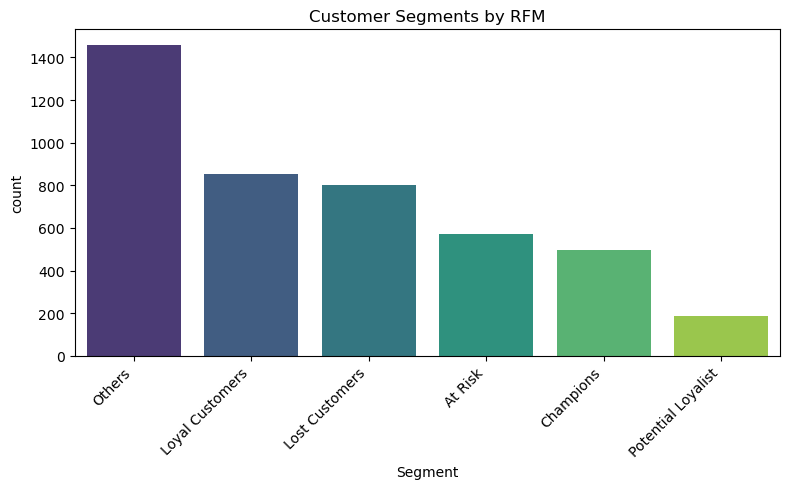

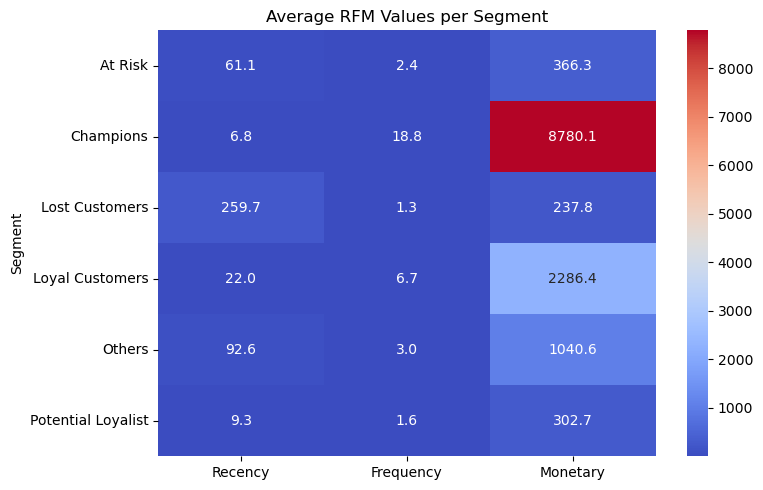

In [10]:
# Count of customers in each segment
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="viridis")
plt.title("Customer Segments by RFM")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Heatmap of average RFM values per segment
plt.figure(figsize=(8,5))
sns.heatmap(rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean(), annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Average RFM Values per Segment")
plt.tight_layout()
plt.show()
